In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
#import shap
import pickle
import matplotlib.colors as mcolors

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
import catboost
from catboost import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve,
    classification_report,
    confusion_matrix
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and process data function
def dataloader(filepath):
    raw_data = pd.read_csv(filepath)
    med_columns = raw_data.columns[raw_data.columns.str.contains('Med_')]
    raw_data[med_columns] = raw_data[med_columns].fillna(0)
    columns_to_rename = raw_data.columns[65:273]
    new_column_names = [col.rsplit('_', 1)[0] for col in columns_to_rename]
    raw_data.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)
    filtered_df = raw_data[raw_data['Is transferred to ICU'] == 1].drop('Is transferred to ICU', axis=1, errors='ignore')
    transform_dtypes_data = filtered_df.copy().iloc[:, 2:]
    category_columns_1 = transform_dtypes_data.columns[
        transform_dtypes_data.columns.str.contains('Med_') | transform_dtypes_data.columns.str.startswith('Diagnosis_')
    ]
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].applymap(lambda x: 0 if x == 0.0 else 1)
    category_columns_2 = ['Gender', 'Insurance', 'Race', 'triage_Acuity', 'Arrival transport']
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].astype('category')
    transform_dtypes_data[category_columns_2] = transform_dtypes_data[category_columns_2].astype('category')
    # print(transform_dtypes_data.dtypes)

    def remove_outliers(df):
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                lower_bound = df[column].quantile(0.01)
                upper_bound = df[column].quantile(0.99)
                df[column] = df[column].apply(lambda v: lower_bound if v < lower_bound else upper_bound if v > upper_bound else v)
            if column == 'Age':
                df[column] = df[column].apply(lambda v: 91 if v > 91 else v)

        return df
        
    
    data = remove_outliers(transform_dtypes_data)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].squeeze()  # Ensure y is a 1D Series
    return X, y

# Feature selection function
def select_features(X, selected_features):
    print(f'Selected feature count: {len(selected_features)}')
    return X[selected_features]

# Model training and evaluation function
def train_and_evaluate(X, y, save_path, params=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    train_data = lgb.Dataset(X_train, label=y_train)
    default_params = {
        "learning_rate": 0.01,
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": ['auc', 'binary_logloss'],
        'verbosity': -1,
    }
    params = params or default_params
    model = lgb.train(params, train_data, 500) 

    # Train and Test metrics
    for split, (X_split, y_split) in {'train': (X_train, y_train), 'test': (X_test, y_test)}.items():
        y_pred_proba = model.predict(X_split)
        if split == 'train':
            fpr, tpr, thresholds_roc = roc_curve(y_split, y_pred_proba)
            youden_index = tpr - fpr
            best_threshold_index = np.argmax(youden_index)
            best_threshold = thresholds_roc[best_threshold_index]
            print()
            print(f"Optimal threshold based on Youden's index: {best_threshold}")    

        auroc = roc_auc_score(y_split, y_pred_proba)
        precision, recall, _ = precision_recall_curve(y_split, y_pred_proba)
        auprc = auc(recall, precision)
        print(f"{split.capitalize()} AUROC: {auroc}")
        print(f"{split.capitalize()} AUPRC: {auprc}")
        
    predict_result = pd.DataFrame({'y_test':y_test,'y_tepred':y_pred_proba}) 
    predict_result.to_csv(save_path, index=False)    

    # y_pred_proba = model.predict(X_train)
    # fpr, tpr, thresholds_roc = roc_curve(y_train, y_pred_proba)
    # youden_index = tpr - fpr
    # best_threshold_index = np.argmax(youden_index)
    # best_threshold = thresholds_roc[best_threshold_index]
    # print()
    # print(f"Optimal threshold based on Youden's index: {best_threshold}")    
    
    y_pred = (y_pred_proba >= best_threshold).astype(int)
    
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print()
    print(report)
    print(conf_matrix)
    return model


In [3]:
cd = '/Users/hnwang/bmc/ihm_icu/fs_framework' 
raw_data_path = '/Users/hnwang/ihm/without_fillna/alldata.csv'
feature_importance_path = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/get_topK_importance_trend/LightGBM_SHAP_imp.csv'
save_path = cd + '/LightGBM/'

if os.path.exists(save_path)==False:
    os.makedirs(save_path)

X, y = dataloader(raw_data_path)

In [4]:
selected_features=X.columns
X_selected = select_features(X, selected_features)

model = train_and_evaluate(X_selected, y, save_path+'predict_result_BFSM.csv')

Selected feature count: 273

Optimal threshold based on Youden's index: 0.15711881454548715
Train AUROC: 0.9298683139722295
Train AUPRC: 0.7140473327553477
Test AUROC: 0.7998893678367018
Test AUPRC: 0.3712815535468764

              precision    recall  f1-score   support

     Class 0      0.938     0.836     0.884      5196
     Class 1      0.294     0.551     0.384       644

    accuracy                          0.805      5840
   macro avg      0.616     0.694     0.634      5840
weighted avg      0.867     0.805     0.829      5840

[[4345  851]
 [ 289  355]]


In [5]:
fs1 = pd.read_excel('/Users/hnwang/bmc/ihm_icu/fs_corr_step1' + '/significantPvalue_ihm.xlsx') #encoding_errors='ignore',,encoding="utf-8"
selected_features=fs1['ID'].tolist()
X_selected = select_features(X, selected_features)

model = train_and_evaluate(X_selected, y, save_path+'predict_result_AFSM-1.csv')

Selected feature count: 168

Optimal threshold based on Youden's index: 0.15078249178298725
Train AUROC: 0.925450198220454
Train AUPRC: 0.7040869455705787
Test AUROC: 0.8003379331449418
Test AUPRC: 0.37052019667481445

              precision    recall  f1-score   support

     Class 0      0.939     0.822     0.877      5196
     Class 1      0.283     0.567     0.378       644

    accuracy                          0.794      5840
   macro avg      0.611     0.695     0.627      5840
weighted avg      0.866     0.794     0.822      5840

[[4273  923]
 [ 279  365]]


In [6]:
imp = pd.read_csv(feature_importance_path)

selected_features=imp.loc[:79-1,:]['Name'].tolist()
X_selected = select_features(X, selected_features)

model = train_and_evaluate(X_selected, y, save_path+'predict_result_AFSM-2.csv')

Selected feature count: 79

Optimal threshold based on Youden's index: 0.14505983242856446
Train AUROC: 0.9244260950243536
Train AUPRC: 0.701605203690007
Test AUROC: 0.8009771611225069
Test AUPRC: 0.37018901126336656

              precision    recall  f1-score   support

     Class 0      0.941     0.810     0.871      5196
     Class 1      0.278     0.592     0.379       644

    accuracy                          0.786      5840
   macro avg      0.610     0.701     0.625      5840
weighted avg      0.868     0.786     0.816      5840

[[4208  988]
 [ 263  381]]


In [7]:
imp = pd.read_csv(feature_importance_path)
selected_features=imp.loc[:79-1,:]['Name'].tolist()

items_to_remove = {
    # "Race",
    "Lab_Absolute Basophil Count",
    "Lab_Absolute Eosinophil Count",
    "Lab_Absolute Monocyte Count",
    "Lab_Alkaline Phosphatase",
    "Lab_Basophils",
    "Lab_Eosinophils",
    "Lab_Immature Granulocytes",
    "Lab_MCHC",
    "Lab_MCH",
    "Lab_MCV",
    # "Med_583.0",
    "Lab_Monocytes",
    "Lab_RBC",
    "Lab_RDW-SD",
    "Lab_Specific Gravity",
    "Med_2747.0",
    "Med_224.0",
    "Med_530.0",
    "Med_2750.0",
    "Med_6094.0",
    "Med_156.0",
    "Med_409.0",
    "Med_225.0",
    "Med_457.0",
    "Med_805.0",
    "Med_320.0",
    # "Diagnosis_F10",
    # "Diagnosis_R53",
    # "triage_Temperature",
    # "triage_HeartRate",
    # "triage_RespiratoryRate"
    # "triage_SBP",
    # "triage_DBP",
    
}

# Use a list comprehension to filter out unwanted items
filtered_list = [item for item in selected_features if item not in items_to_remove]

X_selected = select_features(X, filtered_list)

model = train_and_evaluate(X_selected, y, save_path+'predict_result_AFSM-3.csv')

Selected feature count: 54

Optimal threshold based on Youden's index: 0.14389661243336466
Train AUROC: 0.9171059066238241
Train AUPRC: 0.6802144932160735
Test AUROC: 0.8043128613027699
Test AUPRC: 0.3714828939027134

              precision    recall  f1-score   support

     Class 0      0.944     0.806     0.869      5196
     Class 1      0.281     0.612     0.385       644

    accuracy                          0.785      5840
   macro avg      0.612     0.709     0.627      5840
weighted avg      0.871     0.785     0.816      5840

[[4188 1008]
 [ 250  394]]


### 绘制结果图

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import itertools
#import plot_roc_pr_calibration_curves # this is myself function
from joblib import Parallel, delayed
#from function_Delong_test import DelongTest
import os

cd = '/Users/hnwang/bmc/ihm_icu/fs_framework' 
search_path = cd + '/LightGBM/'
save_path = cd + '/prediction_figure/'


In [3]:
## evaluation
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn import metrics, utils
from joblib import Parallel, delayed
from tqdm import tqdm
import scipy
import scipy.special
import itertools
import yaml
import pickle

##############
#models = ['LR', 'RF', 'CNN_V3', 'RNN_V2', ]
#colors = ['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e']
fig_size = 3
q=10
scipy.interp = np.interp
#################### function only the curve #################

def get_roc_curve(y_true,y_pred):
    roc_curve = metrics.roc_curve(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_pred)
    return roc_curve, auc


def get_pr_curve(y_true,y_pred):
    pr_curve = metrics.precision_recall_curve(y_true, y_pred)
    return pr_curve


def get_calibration_curve(y_true,y_pred,q):
    def get_calibration_plot(y_true, y_prob, q):
        try:
            out, bins = pd.qcut(y_prob.to_numpy(), q=q, labels=False, retbins=True)
            #bins = np.percentile(y_prob.to_numpy(), [0, 20, 40, 60, 80, 100])
            P_true, P_pred = [], []
            for bin_idx in range(q):
                m = (out == bin_idx)
                P_true.append(np.mean(y_true[m]))
                P_pred.append(np.mean(y_prob[m]))
        except:
            print(q)
            print(out)
            raise
        return P_true, P_pred

    p_true, p_pred = get_calibration_plot(y_true, y_pred, q)
    brier_score = np.mean(np.square(np.array(p_true) - np.array(p_pred)))
    print('brier_score = %.3f'%brier_score) 
    cali_curve = [p_true, p_pred]      
    return cali_curve, brier_score 

################ function  the curve and 95%CI ###################
#======= ROC curves
def get_roc_CI_curve(y_true,y_pred):

    def get_roc_curve(y_true,y_pred):
        roc_curve = metrics.roc_curve(y_true, y_pred)
        auc = metrics.roc_auc_score(y_true, y_pred)
        return roc_curve, auc
    
    def bootstrap_func(i,y_true, y_pred):
        y_true_i, y_pred_i = utils.resample(y_true,y_pred,replace=True, random_state=i)
        roc_curve_i = metrics.roc_curve(y_true_i,y_pred_i)
        auc_i = metrics.roc_auc_score(y_true_i, y_pred_i)
        return roc_curve_i, auc_i
    
    def get_roc_CI(y_true, y_pred):
        roc_curves, auc_scores = zip(*Parallel(n_jobs=-1)(delayed(bootstrap_func)(i,y_true,y_pred) for i in range(1000)))
        #roc_curves, auc_scores = [], []
        #for i in range(1000):
        #    roc_curve_i, auc_i = bootstrap_func(i,y_true,y_pred)
        #    roc_curves.append(roc_curve_i)
        #    auc_scores.append(auc_i)
        print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true,y_pred)))
        print('Test AUC:({:.3f},{:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
        #print('Test AUC: {.3f} ({:.3f},{:.3f}) percentile'.format(np.median(auc_scores), np.percentile(auc_scores,2.5),np.percentile(auc_scores,97.5)))
        #print('Test AUC: {.3f} ({:.3f},{:.3f}) empirical'.format(np.mean(auc_scores),np.mean(auc_scores)-1.96 * np.std(auc_scores),np.mean(auc_scores)+1.96 * np.std(auc_scores)))
        
        uci = np.percentile(auc_scores, 97.5)
        dci = np.percentile(auc_scores, 2.5)
        
        tprs = []
        mean_fpr = np.linspace(0,1,100)
        for fpr, tpr,_ in roc_curves:
            tprs.append(scipy.interp(mean_fpr,fpr, tpr)) # np.interp ?
            tprs[-1][0] = 0.0 #?｣ｿ
        
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr+1.96*std_tpr,1)
        tprs_lower = np.maximum(mean_tpr-1.96*std_tpr,0)
        return uci,dci,auc_scores, mean_fpr, tprs_lower, tprs_upper
    
        
    roc_curve, auc = get_roc_curve(y_true,y_pred)
    uci,dci,auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI(y_true, y_pred)
   
    ## save
    '''
    result_roc_CI = {'roc_curve':roc_curve,'auc':auc,'dci':dci,'uci':uci,'auc_scores':auc_scores,
              'mean_fpr':mean_fpr,'tprs_lower':tprs_lower,'tprs_upper':tprs_upper}
    f = open(save_path+'/result_roc_CI.pkl','rb')
    pickle.dump(result_roc_CI, f)
    f.close()
    '''  
    return roc_curve, auc, uci,dci, auc_scores, mean_fpr, tprs_lower, tprs_upper



    
def plot_roc_CI(y_true,y_pred_1,ypred_2):
    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    #fpr,tpr,thresholds = metrics.roc_curve(y_true,y_score)
    # for model_1
    roc_curve, auc_1, uci,dci, auc_scores_1, mean_fpr, tprs_lower, tprs_upper = get_roc_CI_curve(y_true,y_pred_1)
    fpr = roc_curve[0];tpr = roc_curve[1]
    plt.plot(fpr,tpr,lw=1.25, label='model_1', color='green')
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper, alpha=0.1, color='green')

    # for model_2
    roc_curve, auc_2, uci,dci,auc_scores_2, mean_fpr, tprs_lower, tprs_upper = get_roc_CI_curve(y_true,y_pred_2)
    fpr = roc_curve[0], tpr = roc_curve[1]
    plt.plot(fpr,tpr,lw=1.25, label='model_2', color='blue')
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper, alpha=0.1, color='blue')
    
    
    # statistical tests
    pvalue = 2 * min((auc_scores_1 < auc_scores_2).mean(), (auc_scores_1 > auc_scores_2).mean())
    display(pvalue)
    
    
    lg = plt.legend(
        [
            'model_1: {.3f}'.format(auc_1),
            'model_2: {.3f}'.format(auc_2),
        ],
        title = 'AUROC',
        loc = 'lower right',
        handlelength = 1.0,
        fontsize = 9,
    )
    lg.get_title().set_fontsize(10)
    
    plt.plot([0,1],[0,1],'k:')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.title('{}.T={}.dt={}'.format(tast,T,dt))
    plt.tight_layout()
    plt.savefig(save_path+'ROC_curve.png')
    plt.show()
    
    




    
################ function  the curve and 95%CI ###################
#======= PR curves
def get_pr_CI_curve(y_true,y_pred):

    def get_pr_curve(y_true,y_pred):
        pr_curve = metrics.precision_recall_curve(y_true, y_pred)
        pr_auc = metrics.auc(*metrics.precision_recall_curve(y_true,y_pred)[1::-1])
        return pr_curve, pr_auc
    
    def bootstrap_func(i,y_true, y_pred):
        y_true_i, y_pred_i = utils.resample(y_true,y_pred,replace=True, random_state=i)
        pr_curve_i = metrics.precision_recall_curve(y_true_i,y_pred_i)
        pr_auc_i = metrics.auc(*metrics.precision_recall_curve(y_true_i,y_pred_i)[1::-1])
        return pr_curve_i, pr_auc_i
    
    def get_pr_CI(y_true, y_pred):
        pr_curves, pr_auc_scores = zip(*Parallel(n_jobs=-1)(delayed(bootstrap_func)(i,y_true,y_pred) for i in range(1000)))
        #pr_curves, auc_scores = [], []
        #for i in range(1000):
        #    pr_curve_i, pr_auc_i = bootstrap_func(i,y_true,y_pred)
        #    pr_curves.append(pr_curve_i)
        #    pr_auc_scores.append(pr_auc_i)
        print('Test AUPRC: {:.3f}'.format(metrics.auc(*metrics.precision_recall_curve(y_true,y_pred)[1::-1])))
        print('Test AUPRC:({:.3f},{:.3f}) percentile 95% CI'.format(np.percentile(pr_auc_scores, 2.5), np.percentile(pr_auc_scores, 97.5)))
        #print('Test AUPRC: {.3f} ({:.3f},{:.3f}) percentile'.format(np.median(pr_auc_scores), np.percentile(pr_auc_scores,2.5),np.percentile(pr_auc_scores,97.5)))
        #print('Test AUPRC: {.3f} ({:.3f},{:.3f}) empirical'.format(np.mean(pr_auc_scores),np.mean(pr_auc_scores)-1.96 * np.std(pr_auc_scores),np.mean(pr_auc_scores)+1.96 * np.std(pr_auc_scores)))
        
        pr_uci = np.percentile(pr_auc_scores, 97.5)
        pr_dci = np.percentile(pr_auc_scores, 2.5)
        
        precs = []
        mean_rec = np.linspace(0,1,101)
        for prec, rec,_ in pr_curves:
            rec_sorted = rec[np.argsort(rec)]
            prec_sorted = prec[np.argsort(rec)]
            precs.append(np.interp(mean_rec,rec_sorted, prec_sorted))
        
        mean_prec = np.mean(precs, axis=0)
        std_prec = np.std(precs, axis=0)
        prec_upper = np.minimum(mean_prec+1.96*std_prec,1)
        prec_lower = np.maximum(mean_prec-1.96*std_prec,0)
        return pr_uci,pr_dci,pr_auc_scores, mean_rec, prec_lower, prec_upper
    
        
    pr_curve, pr_auc = get_pr_curve(y_true,y_pred)
    pr_uci,pr_dci,pr_auc_scores, mean_rec, prec_lower, prec_upper = get_pr_CI(y_true, y_pred)
   
    ## save
    '''
    result_pr_CI = {'pr_curve':pr_curve,'pr_auc':pr_auc,'pr_dci':pr_dci,'pr_uci':pr_uci,'pr_auc_scores':pr_auc_scores,
              'mean_prec':mean_prec,'prec_lower':prec_lower,'prec_upper':prec_upper}
    f = open(save_path+'/result_pr_CI.pkl','rb')
    pickle.dump(result_pr_CI, f)
    f.close()
    '''  
    return pr_curve, pr_auc, pr_uci,pr_dci, pr_auc_scores, mean_rec, prec_lower, prec_upper

   
def plot_pr_CI(y_true,y_pred_1,y_pred_2):
    fig, ax = plt.subplots(figsize=(fig_size,fig_size))
    #precision, recall, thresholds = metrics.precision_recall_curve(y_true,y_score)
    # for model_1
    pr_curve, pr_auc_1, pr_uci,pr_dci, pr_auc_scores_1, mean_prec, prec_lower, prec_uppe = get_pr_CI_curve(y_true,y_pred_1)
    precison = pr_curve[0], recall = pr_curve[1]
    plt.plot(recall,precision,lw=1.25, label='model_1', color='green')
    plt.fill_between(mean_prec,prec_lower,prec_upper, alpha=0.1, color='green')

    # for model_2
    pr_curve, pr_auc_2, pr_uci,pr_dci, pr_auc_scores_2, mean_prec, prec_lower, prec_uppe = get_roc_CI_curve(y_true,y_pred)
    precison = pr_curve[0]; recall = pr_curve[1]
    plt.plot(recall,precision,lw=1.25, label='model_2', color='blue')
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper, alpha=0.1, color='blue')
    
    
    # statistical tests
    pvalue = 2 * min((pr_auc_scores_1 < pr_auc_scores_2).mean(), (pr_auc_scores_1 > pr_auc_scores_2).mean())
    display(pvalue)
    
    
    lg = plt.legend(
        [
            'model_1: {.3f}'.format(pr_auc_1),
            'model_2: {.3f}'.format(pr_auc_2),
        ],
        title = 'AUPRC',
        loc = 'lower left',
        handlelength = 1.0,
        fontsize = 9,
    )
    lg.get_title().set_fontsize(10)
    
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.title('{}.T={}.dt={}'.format(tast,T,dt))
    plt.tight_layout()
    plt.savefig(save_path+'PR_curve.png')
    plt.show()
    


################ function  the curve and 95%CI ###################
#====Calibration
    
def get_calibration_CI_curve(y_true, y_pred,q):

    def get_calibration_plot(y_true, y_pred, q):
        try:
            out, bins = pd.qcut(y_pred.to_numpy(), q=q, labels=False, retbins=True,duplicates='drop')
            #bins = np.percentile(y_prob.to_numpy(), [0, 20, 40, 60, 80, 100])
            P_true, P_pred = [], []
            for bin_idx in range(q):
                m = (out == bin_idx)
                P_true.append(np.mean(y_true[m]))
                P_pred.append(np.mean(y_pred[m]))
        except:
            print(q)
            #print(out)
            raise
        return P_true, P_pred

    def bootstrap_func(i,y_true,y_pred,q):
        y_true_i, y_pred_i = utils.resample(y_true, y_pred, replace=True, random_state=i)
        P_true, P_pred = get_calibration_plot(y_true_i, y_pred_i, q)
        return P_true, P_pred
        
    def generate_calibration_CI_and_cloud(y_true,y_pred,q):
        P_trues, P_preds = zip(*Parallel(n_jobs=-1)(delayed(bootstrap_func)(i,y_true,y_pred,q=q) for i in range(1000)))
        return P_trues, P_preds
    
    
    P_true, P_pred = get_calibration_plot(y_true, y_pred, q)
    P_trues, P_preds = generate_calibration_CI_and_cloud(y_true,y_pred,q)
    # save
    '''
    result_cali_CI = {'p_true': P_true,'P_pred':P_pred,'P_trues':P_trues,'P_preds':P_preds}
    f = open(save_path+'/result_cali_CI.pkl','rb')
    pickle.dump(result_cali_CI, f)
    f.close()  
    '''  
    return P_true, P_pred, P_trues, P_preds
    

def plot_calibration_CI(y_true, y_pred,q):
    fig = plt.figure(figsize=(figure_size,figure_size))
    #brier_scores = []
    P_true, P_pred, P_trues, P_preds = get_calibration_CI_curves(y_true, y_pred,q)
    brier_score = np.mean(np.square(np.array(P_true)-np.array(P_pred)))
    plt.plot(P_pred, P_true, '.', markersize=5, label=model, color='green',alpha=0.9)
    yerrs = 1.96*np.std(P_trues,axis=0)
    xerrs = 1.96*np.std(P_preds,axis=0)
    markers, caps, bars = plt.errorbar(P_pred,P_true,yerrs,xerrs,'.',markersize=0,elinewidth=1,color='green')
    for bar in bars: bar.set_alpha(0.5)
    for cap in caps: cap.set_alpha(0.5)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    lg = plt.legend(
        [' model_x:{:.4f}'.format(brier_score),
        ],
        loc='lower right',
        handlelength=0.5,
        bbox_to_anchor=(1.02,-0.02),
        fontsize=9,
        title='Brier score',
    )
    lg.get_title().set_fontsize(10)
    plt.plot([0,1],[0,1],'k:')
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0])# for q=5
    
    #plt.title('{}.T={}.dt={}'.format(tast,T,dt))
    plt.tight_layout()
    plt.savefig(save_path+'cali_curve.png')
    plt.show()
        
    
#################################################    
        
#brier_score = np.mean(np.square(np.array(P_true) - np.array(P_pred)))


In [4]:
#### get data and result ##############
# models = ['LR','SVM','KNN','DTC','NB','MLP','RF','XGBoost','Catboost','LightGBM']#
models = ['BFSM','AFSM-1','AFSM-2','AFSM-3']#
preData = {}
for model in models:
    temp = pd.read_csv(search_path +'/predict_result_'+model+'.csv')
    preData[model] = temp
    

#####################################
def get_data(y_true, y_pred,model):
    print('==============model %s begin============='%model) 
    roc_curve, auc, uci,dci, auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI_curve(y_true, y_pred)
    pr_curve, pr_auc, pr_uci,pr_dci, pr_auc_scores, mean_rec, prec_lower, prec_upper = get_pr_CI_curve(y_true, y_pred)
    P_true, P_pred, P_trues, P_preds = get_calibration_CI_curve(y_true, y_pred,10) #q=5
    roc_CI = {'roc_curve':roc_curve,'auc':auc,'dci':dci,'uci':uci,'auc_scores':auc_scores,'mean_fpr':mean_fpr,'tprs_lower':tprs_lower,'tprs_upper':tprs_upper}
    pr_CI = {'pr_curve':pr_curve,'pr_auc':pr_auc,'pr_dci':pr_dci,'pr_uci':pr_uci,'pr_auc_scores':pr_auc_scores,
         'mean_rec':mean_rec,'prec_lower':prec_lower,'prec_upper':prec_upper}
    cali_CI = {'P_true': P_true,'P_pred':P_pred,'P_trues':P_trues,'P_preds':P_preds}
    
    data = {'roc_CI': roc_CI,'pr_CI':pr_CI,'cali_CI':cali_CI}

    if not os.path.exists(os.path.join(save_path, 'results')):
        os.makedirs(os.path.join(save_path, 'results'))

    f = open(save_path+'/results/roc_pr_cali_CI_Model_'+model+'.pkl','wb')
    pickle.dump(data, f)
    f.close()
    print('==============model %s over============='%model)  
    return data

   
for model in models: 
    y_true = preData[model]['y_test']
    y_pred = preData[model]['y_tepred']
    rt = get_data(y_true,y_pred,model)


==============model BFSM begin=============
Test AUC: 0.800
Test AUC:(0.784,0.817) percentile 95% CI
Test AUPRC: 0.371
Test AUPRC:(0.334,0.410) percentile 95% CI
==============model BFSM over=============
==============model AFSM-1 begin=============
Test AUC: 0.800
Test AUC:(0.785,0.818) percentile 95% CI
Test AUPRC: 0.371
Test AUPRC:(0.335,0.410) percentile 95% CI
==============model AFSM-1 over=============
==============model AFSM-2 begin=============
Test AUC: 0.801
Test AUC:(0.785,0.818) percentile 95% CI
Test AUPRC: 0.370
Test AUPRC:(0.333,0.410) percentile 95% CI
==============model AFSM-2 over=============
==============model AFSM-3 begin=============
Test AUC: 0.804
Test AUC:(0.789,0.821) percentile 95% CI
Test AUPRC: 0.371
Test AUPRC:(0.333,0.410) percentile 95% CI
==============model AFSM-3 over=============


In [9]:
import seaborn as sns

# sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

################################### plot figures roc_pc_calibration curves ###########################
# models = ['LR','SVM','KNN','DTC','NB','MLP','RF','XGBoost','Catboost','LightGBM']
# colors =['#2ca02c','#d62728','#1f77b4','#ff7f0e']
if not os.path.exists(os.path.join(save_path, 'figure')):
    os.makedirs(os.path.join(save_path, 'figure'))

models = ['BFSM', 'AFSM-1', 'AFSM-2', 'AFSM-3']

allData = {}
for model in models:
    temp = pickle.load(open(save_path+'/results/roc_pr_cali_CI_Model_'+model+'.pkl','rb'))
    allData[model] = temp


In [10]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics
import numpy as np
from sklearn.metrics import average_precision_score
from scipy.stats import ttest_ind


def compare_pr_auc_significance(y_pred1, y_pred2, y_true, n_bootstraps=1000, random_state=42):
    """
    比较两个模型的PR-AUC差异是否具有统计显著性。
    
    参数:
        y_true (array-like): 真实标签值 (0或1)
        y_pred1 (array-like): 模型1的预测概率
        y_pred2 (array-like): 模型2的预测概率
        n_bootstraps (int): 重采样次数，默认为1000
        random_state (int): 随机种子，默认为42
    
    返回:
        p_value (float): 两个模型的PR-AUC差异的p值
    """
    def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, random_state=None):
        rng = np.random.RandomState(random_state)
        scores = []
        for _ in range(n_bootstraps):
            # 随机采样有放回的子样本
            indices = rng.randint(0, len(y_pred), len(y_pred))
            if len(np.unique(y_true[indices])) < 2:
                # 跳过没有正负类的情况
                continue
            score = average_precision_score(y_true[indices], y_pred[indices])
            scores.append(score)
        return np.array(scores)

    # 计算两个模型的PR-AUC分布
    auc_scores_model1 = bootstrap_auc(y_true, y_pred1, n_bootstraps=n_bootstraps, random_state=random_state)
    auc_scores_model2 = bootstrap_auc(y_true, y_pred2, n_bootstraps=n_bootstraps, random_state=random_state)

    # 进行双样本t检验来比较两个模型的PR-AUC
    stat, p_value = ttest_ind(auc_scores_model1, auc_scores_model2)

    return p_value

def compare_pr_auc_significance_2(y_pred1, y_pred2, y_true, n_bootstraps=1000, random_state=42):
    """
    比较两个模型的PR-AUC差异是否具有统计显著性。
    
    参数:
        y_true (array-like): 真实标签值 (0或1)
        y_pred1 (array-like): 模型1的预测概率
        y_pred2 (array-like): 模型2的预测概率
        n_bootstraps (int): 重采样次数，默认为1000
        random_state (int): 随机种子，默认为42
    
    返回:
        p_value (float): 两个模型的PR-AUC差异的p值
    """
    def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, random_state=None):
        rng = np.random.RandomState(random_state)
        scores = []
        for _ in range(n_bootstraps):
            # 随机采样有放回的子样本
            indices = rng.randint(0, len(y_pred), len(y_pred))
            if len(np.unique(y_true[indices])) < 2:
                # 跳过没有正负类的情况
                continue
            score = average_precision_score(y_true[indices], y_pred[indices])
            scores.append(score)
        return np.array(scores)

    # 计算两个模型的PR-AUC分布
    auc_scores_model1 = bootstrap_auc(y_true, y_pred1, n_bootstraps=n_bootstraps, random_state=random_state)
    auc_scores_model2 = bootstrap_auc(y_true, y_pred2, n_bootstraps=n_bootstraps, random_state=random_state)

    # 计算p值 (随机排列检验)
    p_value = 2 * min(
        np.mean(auc_scores_model1 < auc_scores_model2),
        np.mean(auc_scores_model1 > auc_scores_model2)
    )
    print(p_value)
    return p_value


class DelongTest():
    def __init__(self,preds1,preds2,label,threshold=0.05):
        '''
        preds1:the output of model1
        preds2:the output of model2
        label :the actual label
        '''
        self._preds1=preds1
        self._preds2=preds2
        self._label=label
        self.threshold=threshold
        # self._show_result()

    def _auc(self,X, Y)->float:
        return 1/(len(X)*len(Y)) * sum([self._kernel(x, y) for x in X for y in Y])

    def _kernel(self,X, Y)->float:
        '''
        Mann-Whitney statistic
        '''
        return .5 if Y==X else int(Y < X)

    def _structural_components(self,X, Y)->list:
        V10 = [1/len(Y) * sum([self._kernel(x, y) for y in Y]) for x in X]
        V01 = [1/len(X) * sum([self._kernel(x, y) for x in X]) for y in Y]
        return V10, V01

    def _get_S_entry(self,V_A, V_B, auc_A, auc_B)->float:
        return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
    
    def _z_score(self,var_A, var_B, covar_AB, auc_A, auc_B):
        return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB )**(.5)+ 1e-8)

    def _group_preds_by_label(self,preds, actual)->list:
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y

    def _compute_z_p(self):
        X_A, Y_A = self._group_preds_by_label(self._preds1, self._label)
        X_B, Y_B = self._group_preds_by_label(self._preds2, self._label)

        V_A10, V_A01 = self._structural_components(X_A, Y_A)
        V_B10, V_B01 = self._structural_components(X_B, Y_B)

        auc_A = self._auc(X_A, Y_A)
        auc_B = self._auc(X_B, Y_B)

        # Compute entries of covariance matrix S (covar_AB = covar_BA)
        var_A = (self._get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)+ self._get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
        var_B = (self._get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)+ self._get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
        covar_AB = (self._get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)+ self._get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

        # Two tailed test
        z = self._z_score(var_A, var_B, covar_AB, auc_A, auc_B)
        p = st.norm.sf(abs(z))*2

        return z,p

    def _show_result(self):
        z, p=self._compute_z_p()
        print(f"z score = {z:.5f};\np value = {p:.5f};")
        if p < self.threshold :
            print("There is a significant difference")
        else:        
            print("There is NO significant difference")
        return p


In [11]:
p_values_auroc = pd.DataFrame(np.ones((len(models), len(models))), index=models, columns=models)
p_values_auprc = pd.DataFrame(np.ones((len(models), len(models))), index=models, columns=models)

for i, s in enumerate(models):
    for j, j_model in enumerate(models):
        if i <= j:
            print(f'============ {s} vs {j_model} ============')
            dataA = pd.read_csv(search_path + f'predict_result_{s}.csv')
            dataB = pd.read_csv(search_path + f'predict_result_{j_model}.csv')
            
            delong_test_instance = DelongTest(dataA['y_tepred'], dataB['y_tepred'], dataA['y_test'])
            p = delong_test_instance._show_result()
            p_values_auroc.loc[s, j_model] = p  
            
            p = compare_pr_auc_significance_2(dataA['y_tepred'], dataB['y_tepred'], dataA['y_test'])
            p_values_auprc.loc[s, j_model] = p

============ BFSM vs BFSM ============
z score = 0.00000;
p value = 1.00000;
There is NO significant difference
0.0
============ BFSM vs AFSM-1 ============
z score = -0.35989;
p value = 0.71893;
There is NO significant difference
0.802
============ BFSM vs AFSM-2 ============
z score = -0.81590;
p value = 0.41455;
There is NO significant difference
0.7
============ BFSM vs AFSM-3 ============
z score = -1.70643;
p value = 0.08793;
There is NO significant difference
0.976
============ AFSM-1 vs AFSM-1 ============
z score = 0.00000;
p value = 1.00000;
There is NO significant difference
0.0
============ AFSM-1 vs AFSM-2 ============
z score = -0.72460;
p value = 0.46870;
There is NO significant difference
0.854
============ AFSM-1 vs AFSM-3 ============
z score = -1.52940;
p value = 0.12616;
There is NO significant difference
0.93
============ AFSM-2 vs AFSM-2 ============
z score = 0.00000;
p value = 1.00000;
There is NO significant difference
0.0
============ AFSM-2 vs AFSM-3 ========

In [12]:
p_values_auprc

,BFSM,AFSM-1,AFSM-2,AFSM-3
BFSM,0.0,0.802,0.700,0.976
AFSM-1,1.0,0.000,0.854,0.930
AFSM-2,1.0,1.000,0.000,0.854
AFSM-3,1.0,1.000,1.000,0.000


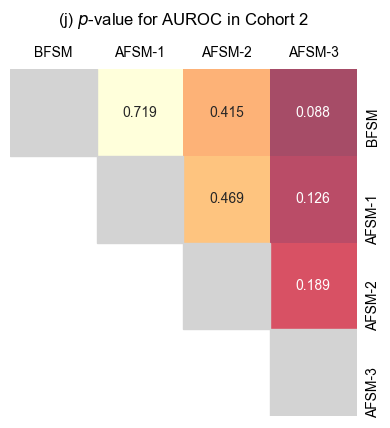

In [27]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# mask = np.tril(np.ones(p_values_auroc.shape), k=-1).astype(bool)

# plt.figure(figsize=(4.5, 4.5))
# ax = sns.heatmap(p_values_auroc, mask=mask, annot=True, cmap="YlGnBu_r", fmt=".3f", cbar=False, alpha=0.8)

# ax.yaxis.tick_right()
# ax.tick_params(axis='y', which='both', left=False, right=False)  # Hide tick marks for y-axis
# ax.xaxis.tick_top()
# ax.tick_params(axis='x', which='both', top=False, bottom=False)  # Hide tick marks for x-axis

# ax.set_title("(b) $p$-value for AUROC in Cohort 2", fontsize=12, pad=15)

# plt.savefig(os.path.join(save_path, 'heatmap_auroc.png'), dpi=300, bbox_inches='tight')
# plt.show()            

mask = np.eye(p_values_auroc.shape[0], dtype=bool)
p_values_auroc[mask] = np.nan
mask = np.tril(np.ones(p_values_auroc.shape), k=-1).astype(bool)

# plt.figure(figsize=(4.5, 4.5))
# ax = sns.heatmap(p_values_auroc, mask=mask, annot=True, cmap="YlGnBu_r", fmt=".3f", cbar=False, alpha=0.8)
# mask = np.tril(np.ones(p_values_auprc.shape), k=-1).astype(bool)

plt.figure(figsize=(4.5, 4.5))
# ax = sns.heatmap(p_values_auprc, mask=mask, annot=True, cmap="YlOrRd_r", fmt=".3f", cbar=False, alpha=0.8)
# 绘制热力图，不显示对角线的数字并设置灰色遮罩
# plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    p_values_auroc, 
    mask=mask, 
    annot=True, 
    cmap="YlOrRd_r", 
    fmt=".3f", 
    cbar=False, 
    annot_kws={"size": 10}, 
    square=True,
    linewidths=0.5,
    alpha=0.7,
    linecolor="None"  # 设置遮罩的边框为灰色
)

# 将对角线位置填充为灰色
for i in range(len(p_values_auprc)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="lightgray"))

# plt.show()

ax.yaxis.tick_right()
ax.tick_params(axis='y', which='both', left=False, right=False)  # Hide tick marks for y-axis
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='both', top=False, bottom=False)  # Hide tick marks for x-axis

ax.set_title("(j) $p$-value for AUROC in Cohort 2", fontsize=12, pad=15)

plt.savefig(os.path.join(save_path, 'heatmap_auroc_2.png'), dpi=300, bbox_inches='tight')
plt.show()            

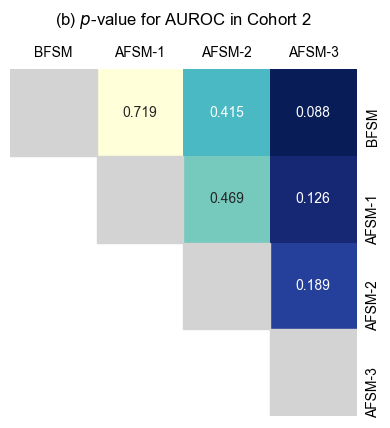

In [21]:

# mask = np.tril(np.ones(p_values_auprc.shape), k=-1).astype(bool)

# plt.figure(figsize=(4.5, 4.5))
# # ax = sns.heatmap(p_values_auprc, mask=mask, annot=True, cmap="YlOrRd_r", fmt=".3f", cbar=False, alpha=0.8)
# # 绘制热力图，不显示对角线的数字并设置灰色遮罩
# # plt.figure(figsize=(8, 6))
# ax = sns.heatmap(
#     p_values_auprc, 
#     mask=mask, 
#     annot=True, 
#     cmap="YlOrRd_r", 
#     fmt=".3f", 
#     cbar=False, 
#     annot_kws={"size": 12}, 
#     square=True,
#     linewidths=0.5,
#     linecolor="None"  # 设置遮罩的边框为灰色
# )

# # 将对角线位置填充为灰色
# for i in range(len(p_values_auprc)):
#     ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="gray"))

# # plt.show()

# ax.yaxis.tick_right()
# ax.tick_params(axis='y', which='both', left=False, right=False)  # Hide tick marks for y-axis
# ax.xaxis.tick_top()
# ax.tick_params(axis='x', which='both', top=False, bottom=False)  # Hide tick marks for x-axis

# ax.set_title("(c) $p$-value for AUPRC in Cohort 2", fontsize=12, pad=15)

# plt.savefig(os.path.join(save_path, 'heatmap_auprc_2.png'), dpi=300, bbox_inches='tight')
# plt.show()            

mask = np.eye(p_values_auprc.shape[0], dtype=bool)
p_values_auroc[mask] = np.nan
mask = np.tril(np.ones(p_values_auprc.shape), k=-1).astype(bool)

# plt.figure(figsize=(4.5, 4.5))
# ax = sns.heatmap(p_values_auroc, mask=mask, annot=True, cmap="YlGnBu_r", fmt=".3f", cbar=False, alpha=0.8)
# mask = np.tril(np.ones(p_values_auprc.shape), k=-1).astype(bool)

plt.figure(figsize=(4.5, 4.5))
# ax = sns.heatmap(p_values_auprc, mask=mask, annot=True, cmap="YlOrRd_r", fmt=".3f", cbar=False, alpha=0.8)
# 绘制热力图，不显示对角线的数字并设置灰色遮罩
# plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    p_values_auroc, 
    mask=mask, 
    annot=True, 
    cmap="YlGnBu_r", 
    fmt=".3f", 
    cbar=False, 
    annot_kws={"size": 10}, 
    square=True,
    linewidths=0.5,
    linecolor="None"  # 设置遮罩的边框为灰色
)

# 将对角线位置填充为灰色
for i in range(len(p_values_auprc)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color="lightgray"))

# plt.show()

ax.yaxis.tick_right()
ax.tick_params(axis='y', which='both', left=False, right=False)  # Hide tick marks for y-axis
ax.xaxis.tick_top()
ax.tick_params(axis='x', which='both', top=False, bottom=False)  # Hide tick marks for x-axis

ax.set_title("(b) $p$-value for AUROC in Cohort 2", fontsize=12, pad=15)

plt.savefig(os.path.join(save_path, 'heatmap_auroc_2.png'), dpi=300, bbox_inches='tight')
plt.show()            

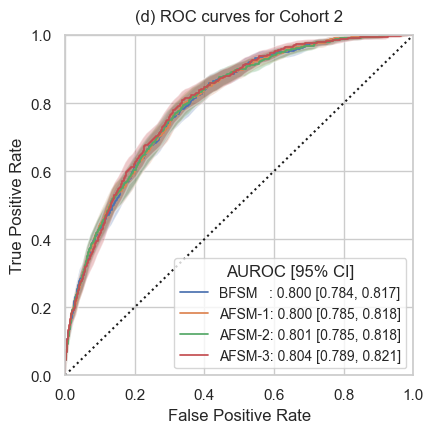

In [17]:
sns.set_theme(style="whitegrid")

def draw_roc_curve():
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    for model in models:
        data = allData[model]['roc_CI']
        fpr = data['roc_curve'][0]
        tpr = data['roc_curve'][1]
        mean_fpr = data['mean_fpr']
        tprs_lower = data['tprs_lower']
        tprs_upper = data['tprs_upper']
        if model=='BFSM':
            label = f"{model}   : {data['auc']:.3f} [{data['dci']:.3f}, {data['uci']:.3f}]"
        else:
            label = f"{model}: {data['auc']:.3f} [{data['dci']:.3f}, {data['uci']:.3f}]"
        ax.plot(fpr, tpr, lw=1.25, label=label)
        
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.3)
        
    ax.plot([0, 1], [0, 1], 'k:')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('(d) ROC curves for Cohort 2', fontsize=12, pad=10)
    ax.legend(title='AUROC [95% CI]', loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'roc_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

draw_roc_curve()

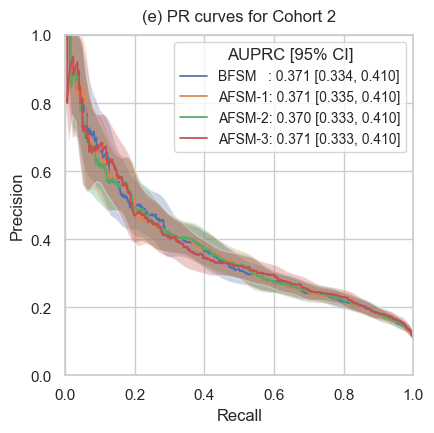

In [18]:
def draw_pr_curve():
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    for model in models:
        data = allData[model]['pr_CI']
        precision = data['pr_curve'][0]
        recall = data['pr_curve'][1]
        mean_rec = data['mean_rec']
        prec_lower = data['prec_lower']
        prec_upper = data['prec_upper']
        
        if model=='BFSM':
            label=f"{model}   : {data['pr_auc']:.3f} [{data['pr_dci']:.3f}, {data['pr_uci']:.3f}]"
        else:
            label=f"{model}: {data['pr_auc']:.3f} [{data['pr_dci']:.3f}, {data['pr_uci']:.3f}]"
        ax.plot(recall, precision, lw=1.25, label=label)
        
        ax.fill_between(mean_rec, prec_lower, prec_upper, alpha=0.3)
        
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('(e) PR curves for Cohort 2', fontsize=12, pad=10)
    ax.legend(title='AUPRC [95% CI]', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'pr_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

draw_pr_curve()

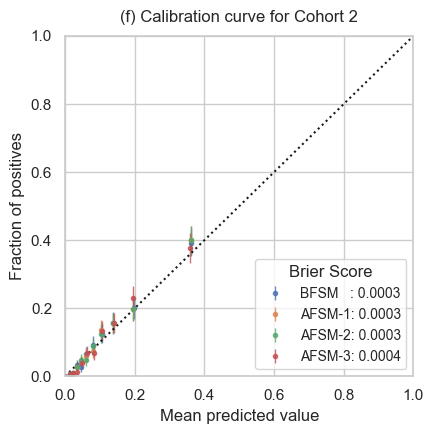

In [19]:
def draw_calibration_curve():
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    for model in models:
        data = allData[model]['cali_CI']
        P_pred = data['P_pred']
        P_true = data['P_true']
        yerrs = 1.96 * np.std(data['P_trues'], axis=0)
        
        if model=='BFSM':
            label=f"{model}   : {np.mean(np.square(np.array(P_true)-np.array(P_pred))):.4f}"
        else:
            label=f"{model}: {np.mean(np.square(np.array(P_true)-np.array(P_pred))):.4f}"

        ax.errorbar(P_pred, P_true, yerr=yerrs, fmt='.', markersize=6, label=label, elinewidth=1, alpha=0.8)
    ax.plot([0, 1], [0, 1], 'k:')
    ax.set_xlabel('Mean predicted value')
    ax.set_ylabel('Fraction of positives')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('(f) Calibration curve for Cohort 2', fontsize=12, pad=10)
    ax.legend(title='Brier Score', loc='lower right', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'calibration_curve.png'), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

draw_calibration_curve()

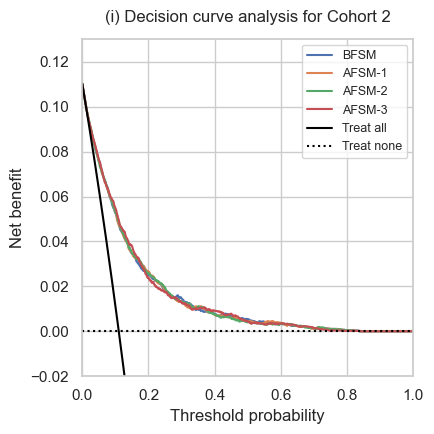

In [14]:
sns.set_theme(style="whitegrid")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd


cd = '/Users/hnwang/bmc/ihm_icu/fs_framework' 
search_path = cd + '/LightGBM/'
save_path = cd + '/prediction_figure/figure/'

data={}   
######################

def calculate_net_benefit_model(thresh_group,y_pred_score,y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp/n) - (fp/n)*(thresh/(1-thresh))
        net_benefit_model = np.append(net_benefit_model,net_benefit)
    return net_benefit_model
    
def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all =  np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp/total)-(tn/total)*(thresh/(1-thresh))
        net_benefit_all = np.append(net_benefit_all,net_benefit)
    return net_benefit_all


#########
thresh_group = np.arange(0,1,0.001)
plt.figure(figsize=(4.5, 4.5))

models = ['BFSM','AFSM-1','AFSM-2','AFSM-3']
colors =['#2ca02c','#d62728','#1f77b4','#ff7f0e']
for model in models:
    temp = pd.read_csv(search_path +'/predict_result_'+model+'.csv')
    data[model] = temp
for model in models:   
    net_benefit_model = calculate_net_benefit_model(thresh_group,data[model]['y_tepred'],data[model]['y_test']) 
    plt.plot(thresh_group,net_benefit_model,label= model)#color=colors[s],
net_benefit_all = calculate_net_benefit_all(thresh_group, data[model]['y_test'])
plt.plot(thresh_group,net_benefit_all, color='black',label='Treat all')
plt.plot((0,1),(0,0),color='black',linestyle=':',label='Treat none')
    
#figure congiguration
plt.xlim(0,1)
plt.ylim(net_benefit_model.min()-0.02,net_benefit_model.max()+0.02)
plt.xlabel('Threshold probability')
plt.ylabel('Net benefit')
plt.legend(loc='upper right',fontsize=9)
plt.title('(i) Decision curve analysis for Cohort 2', fontsize=12, pad=12)
plt.tight_layout()
plt.savefig(save_path+'/DCA_curves_figure_MIMIC.png',dpi=300,bbox_inches='tight')
#plt.savefig(save_path+'/DCA_curves_figure_HERON.eps',format='eps',dpi=300,bbox_inches='tight')
#plt.show()
